In [1]:
!pip install -q pyvi 
!pip install --upgrade scikit-learn joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 61.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.8.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.8.0 which is incompatible.


In [2]:
!pip install -q pyvi scikit-learn transformers torch accelerate seaborn tqdm

import json
import os
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
from pyvi import ViTokenizer
import shutil

if torch.cuda.device_count() > 1:
    print(f"Running on Multi-GPU: {torch.cuda.device_count()} devices")
    BATCH_SIZE = 32
else:
    print("Running on Single GPU or CPU")
    BATCH_SIZE = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seed
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

# Schema Valid
IGNORED_LABELS = {'PER_VICTIMPACT', 'CAUSES', 'CONSEQUENCES'}
VALID_SCHEMA = {
    'LOCATED_AT': [('EVENT', 'LOC')],
    'HAPPENED_ON': [('EVENT', 'TIME')],
    'INVOLVED': [('EVENT', 'VEH'), ('PER_DRIVER', 'VEH'), ('PER_VICTIM', 'VEH')],
    'CAUSED_BY': [('EVENT', 'CAUSE')],
    'HAS_CONSEQUENCE': [('EVENT', 'CONSEQUENCE')]
}

def is_valid_relation(label, s_type, o_type):
    if label in IGNORED_LABELS: return False
    if label not in VALID_SCHEMA: return False
    return (s_type, o_type) in VALID_SCHEMA[label]


# 2. LOAD DATA - TYPED ENTITY MARKERS

import itertools
import json
import os
from pyvi import ViTokenizer
from sklearn.model_selection import train_test_split

DATA_PATH = '/kaggle/input/nlp-dataset-v2/output.json'

# CẤU HÌNH SCHEMA

VALID_SCHEMA = {
    'LOCATED_AT':      [('EVENT', 'LOC')], 
    'HAPPENED_ON':     [('EVENT', 'TIME')],
    'INVOLVED':        [('EVENT', 'VEH'),  ('PER_DRIVER', 'VEH'), ('PER_VICTIM', 'VEH')],
    'CAUSED_BY':       [('EVENT', 'CAUSE')], 
    'HAS_CONSEQUENCE': [('EVENT', 'CONSEQUENCE')]
}

ALLOWED_TYPE_PAIRS = set()
for rel, pairs in VALID_SCHEMA.items():
    for p in pairs: ALLOWED_TYPE_PAIRS.add(p)

print(f" Schema Filter: {len(ALLOWED_TYPE_PAIRS)} cặp hợp lệ.")
print(" Đã loại bỏ hoàn toàn: PER_VICTIMPACT, CAUSES, CONSEQUENCES.")

# HÀM CHÈN THẺ TYPED MARKERS
def process_text_typed(text, e1, e2):
    try:
        l1 = e1['label'] 
        l2 = e2['label'] 
        
        tag1_open, tag1_close = f" <S:{l1}> ", f" </S:{l1}> "
        tag2_open, tag2_close = f" <O:{l2}> ", f" </O:{l2}> "
        
        spans = [
            (int(e1['start']), tag1_open), (int(e1['end']), tag1_close),
            (int(e2['start']), tag2_open), (int(e2['end']), tag2_close)
        ]
        spans.sort(key=lambda x: x[0], reverse=True)
        
        processed_text = text
        for idx, token in spans:
            processed_text = processed_text[:idx] + token + processed_text[idx:]
            
        return ViTokenizer.tokenize(processed_text)
    except Exception as e:
        return ""

def load_data(path):
    if not os.path.exists(path): return [], set()
    with open(path, 'r', encoding='utf-8') as f: data = json.load(f)
    
    samples = []
    found_labels = set()
    
    for task in data:
        text = task.get('data', {}).get('text') or task.get('text')
        if not text: continue
        
        annotations = task.get('annotations', [])
        if not annotations: continue
        res = annotations[0].get('result', [])
        
        ents, rels = {}, {}
        
        # Trích xuất Entity & Label
        for i in res:
            if i['type'] == 'labels':
                if 'id' not in i: continue 
                
                eid = i['id']
                val = i['value']
                
                if 'labels' in val and len(val['labels']) > 0:
                    lbl = val['labels'][0]
                    
            
                    if lbl in ['PER_VICTIMPACT', 'CAUSES', 'CONSEQUENCES']:
                        continue

                    found_labels.add(lbl)
                    ents[eid] = {
                        'start': val['start'], 
                        'end': val['end'], 
                        'label': lbl
                    }
                    
            elif i['type'] == 'relation':
                if 'labels' in i and len(i['labels']) > 0:
                    rels[(i['from_id'], i['to_id'])] = i['labels'][0]
        
        # Duyệt cặp tạo data
        ent_ids = list(ents.keys())
        for e1_id in ent_ids:
            for e2_id in ent_ids:
                if e1_id == e2_id: continue
                
                e1, e2 = ents[e1_id], ents[e2_id]
                
                # Filter theo Schema (Bước này sẽ chặn triệt để)
                if (e1['label'], e2['label']) not in ALLOWED_TYPE_PAIRS:
                    continue
                
                # Lấy nhãn quan hệ
                label = rels.get((e1_id, e2_id), "NO_RELATION")
                if 'IGNORED_LABELS' in globals() and label in IGNORED_LABELS: continue
                
                # Xử lý text
                processed = process_text_typed(text, e1, e2)
                if processed:
                    samples.append({'text': processed, 'label': label})
                    
    return samples, found_labels

# EXECUTE
print("Đang xử lý dữ liệu với Typed Markers...")
raw_data, all_entity_types = load_data(DATA_PATH)

if len(raw_data) == 0:
    print(" LỖI: Không tìm thấy mẫu dữ liệu nào sau khi lọc!")
else:
    print(f" Tổng số mẫu: {len(raw_data)}")
    print(f" Các loại thực thể được giữ lại: {all_entity_types}")

    # Tạo SPECIAL_TOKENS
    SPECIAL_TOKENS = []
    for lbl in all_entity_types:
        SPECIAL_TOKENS.extend([f"<S:{lbl}>", f"</S:{lbl}>", f"<O:{lbl}>", f"</O:{lbl}>"])

    print(f" Đã tạo {len(SPECIAL_TOKENS)} tokens đặc biệt.")

    # Tạo Label Mapping
    label2id = {l: i for i, l in enumerate(sorted(list(set([x['label'] for x in raw_data]))))}
    if "NO_RELATION" in label2id:
        all_lbl = sorted(list(label2id.keys()))
        all_lbl.remove("NO_RELATION")
        all_lbl.insert(0, "NO_RELATION")
        label2id = {l: i for i, l in enumerate(all_lbl)}
        
    id2label = {i: l for l, i in label2id.items()} 

    # Chia tập dữ liệu
    try:
        train_data, test_data = train_test_split(raw_data, test_size=0.2, stratify=[x['label'] for x in raw_data], random_state=42)
        print(f" Train set: {len(train_data)} | Test set: {len(test_data)}")
    except ValueError as e:
        print(f" Lỗi chia dữ liệu: {e}")
        train_data, test_data = train_test_split(raw_data, test_size=0.2, random_state=42)
        print(f" (Fallback) Train set: {len(train_data)} | Test set: {len(test_data)}")


# 3. FEATURE EXTRACTION FOR ML

print("\n Đang trích xuất đặc trưng cho ML")
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
import gc

# 1. SETUP TOKENIZER & MODEL

if 'SPECIAL_TOKENS' not in globals():
    raise ValueError(" Lỗi: Biến SPECIAL_TOKENS chưa tồn tại. Hãy chạy lại Cell 2 trước!")

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
tokenizer.add_special_tokens({'additional_special_tokens': SPECIAL_TOKENS})

base_model = AutoModel.from_pretrained("vinai/phobert-base")
base_model.resize_token_embeddings(len(tokenizer)) 

if torch.cuda.device_count() > 1:
    print(f" Sử dụng {torch.cuda.device_count()} GPUs!")
    base_model = nn.DataParallel(base_model)

base_model.to(device).eval()
print(f" Tokenizer & Model đã cập nhật. Vocab size mới: {len(tokenizer)}")

# 2. HÀM TRÍCH XUẤT VECTOR
def extract_vectors(dataset, batch_size=32):
    texts = [item['text'] for item in dataset]
    # Lấy nhãn từ label2id đã tạo ở Cell 2
    labels = [label2id[item['label']] for item in dataset]
    all_vecs = []
    

    for i in tqdm(range(0, len(texts), batch_size), desc="Vectorizing"):
        batch_text = texts[i:i+batch_size]
        
        with torch.no_grad():
            # Tokenize batch
            inputs = tokenizer(batch_text, padding=True, truncation=True, max_length=256, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = base_model(**inputs)
            
            # --- Mean Pooling ---

            mask = inputs['attention_mask'].unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
            sum_emb = torch.sum(outputs.last_hidden_state * mask, 1)
            sum_mask = torch.clamp(mask.sum(1), min=1e-9)
            mean_emb = sum_emb / sum_mask
            
            all_vecs.append(mean_emb.cpu().numpy())
            
    return np.vstack(all_vecs), np.array(labels)

# 3. THỰC HIỆN
print(f"--> Xử lý tập Train ({len(train_data)} mẫu):")
X_train_ml, y_train_ml = extract_vectors(train_data)

print(f"--> Xử lý tập Test ({len(test_data)} mẫu):")
X_test_ml, y_test_ml = extract_vectors(test_data)

print(f" Hoàn tất! Kích thước Vector Train: {X_train_ml.shape}")

del base_model
torch.cuda.empty_cache()
gc.collect()

2025-12-23 15:14:45.718289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766502885.742987    1781 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766502885.750365    1781 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Running on Multi-GPU: 2 devices
 Schema Filter: 7 cặp hợp lệ.
 Đã loại bỏ hoàn toàn: PER_VICTIMPACT, CAUSES, CONSEQUENCES.
Đang xử lý dữ liệu với Typed Markers...
 Tổng số mẫu: 25491
 Các loại thực thể được giữ lại: {'VEH', 'CONSEQUENCE', 'EVENT', 'CAUSE', 'PER_DRIVER', 'ORG', 'PER_VICTIM', 'TIME', 'LOC'}
 Đã tạo 36 tokens đặc biệt.
 Train set: 20392 | Test set: 5099

 Đang trích xuất đặc trưng cho ML


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

 Sử dụng 2 GPUs!
 Tokenizer & Model đã cập nhật. Vocab size mới: 64037
--> Xử lý tập Train (20392 mẫu):


Vectorizing: 100%|██████████| 638/638 [03:04<00:00,  3.45it/s]


--> Xử lý tập Test (5099 mẫu):


Vectorizing: 100%|██████████| 160/160 [00:45<00:00,  3.48it/s]


 Hoàn tất! Kích thước Vector Train: (20392, 768)


0

Đã kết nối với thư mục model: ['metadata.pkl', 'lr_model.joblib', 'rf_model.joblib', 'svm_model.joblib', 'phobert_finetuned']
Đang load và dự đoán với SVM...
Đang load và dự đoán với RandomForest...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator LinearSVC from version 1.6.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.8.0. This might lead to breaki

Đang load và dự đoán với LogisticRegression...
Đang load và dự đoán với PhoBERT...

                                 BẢNG TỔNG HỢP                                  
+--------------------+--------------------+--------------------+--------------------+--------------------+
|       Model        |      Accuracy      |       Recall       |      F1-Macro      |      F1-Micro      |
+--------------------+--------------------+--------------------+--------------------+--------------------+
|        SVM         | 0.5513959390862944 | 0.5513959390862944 | 0.5795293540282088 | 0.5513959390862944 |
|    RandomForest    | 0.1998730964467005 | 0.1998730964467005 | 0.2296712466817552 | 0.1998730964467005 |
| LogisticRegression | 0.5044416243654822 | 0.5044416243654822 | 0.5465341816918214 | 0.5044416243654822 |
|      PhoBERT       | 0.8572335025380711 | 0.8572335025380711 | 0.7741567820922498 | 0.8572335025380711 |
+--------------------+--------------------+--------------------+--------------------+-

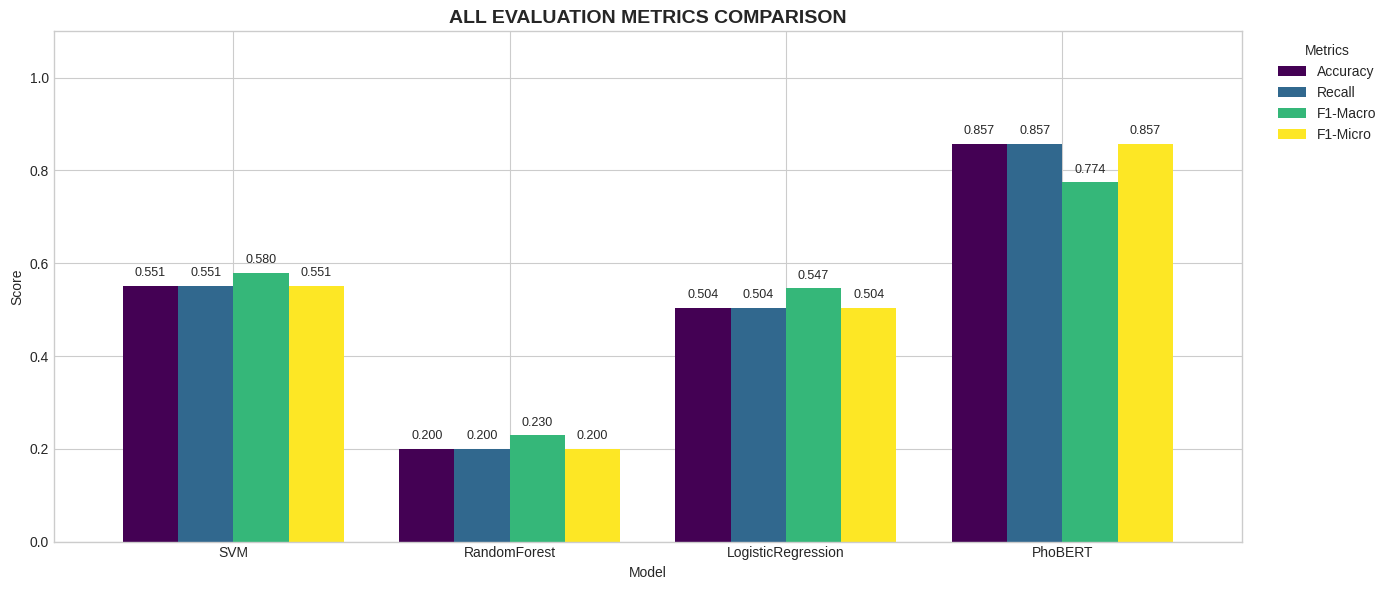

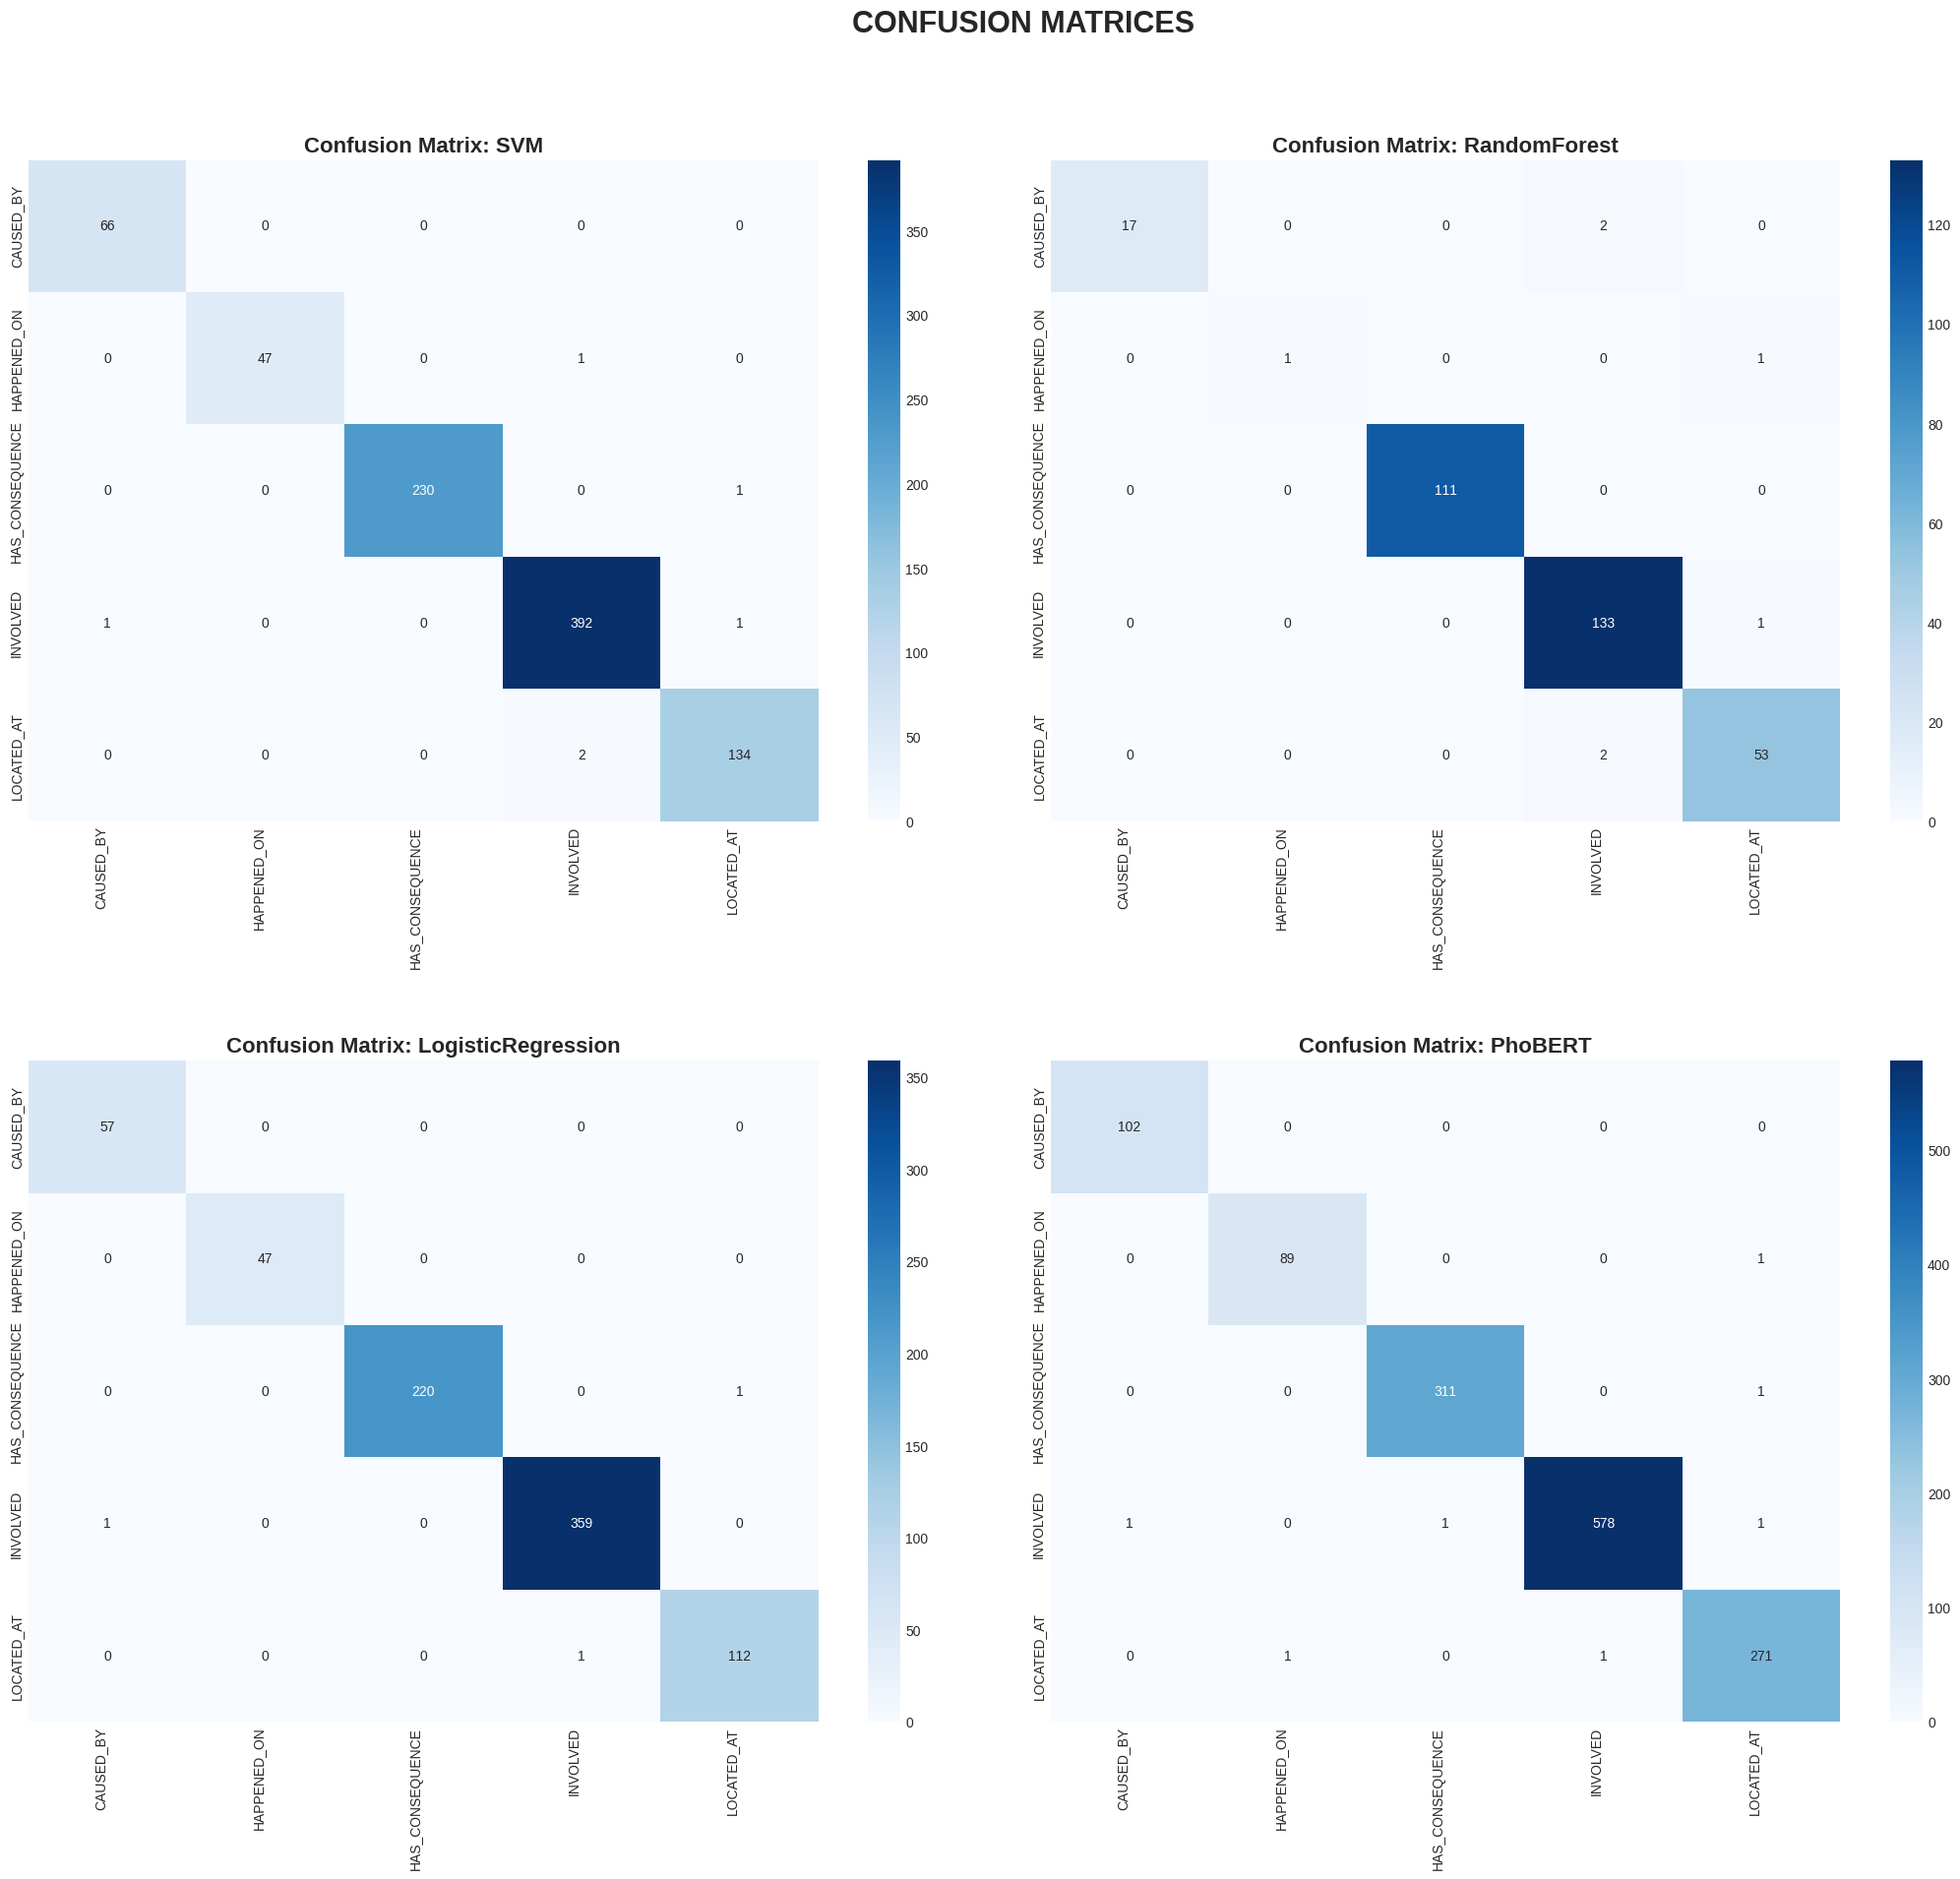

In [3]:


import subprocess
import sys

def update_sklearn():
    try:
        import sklearn
        from packaging import version
        if version.parse(sklearn.__version__) < version.parse("1.5.0"):
            print(f"Phiên bản sklearn hiện tại ({sklearn.__version__}) quá cũ. Đang nâng cấp lên 1.6.1...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "scikit-learn==1.6.1", "joblib"])
            print("Nâng cấp thành công")
    except Exception as e:
        print(f"Không thể tự động nâng cấp: {e}")

update_sklearn()

import os
import joblib
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from tabulate import tabulate
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# 1. CẤU HÌNH ĐƯỜNG DẪN 

MODEL_DIR = "/kaggle/input/re-final-models-v3" 

if not os.path.exists(MODEL_DIR):
    print(f"Cảnh báo: Không tìm thấy thư mục {MODEL_DIR}.")
else:
    print(f"Đã kết nối với thư mục model: {os.listdir(MODEL_DIR)}")


# 2. LOAD MÔ HÌNH VÀ DỰ ĐOÁN

results_list = []
all_predictions = {}

# Machine Learning
ml_configs = [("SVM", "svm_model.joblib"), ("RandomForest", "rf_model.joblib"), ("LogisticRegression", "lr_model.joblib")]
for name, file_name in ml_configs:
    path = os.path.join(MODEL_DIR, file_name)
    if os.path.exists(path):
        try:
            print(f"Đang load và dự đoán với {name}...")
            model = joblib.load(path)
            # X_test_ml lấy từ cell Feature Extraction của bạn
            all_predictions[name] = model.predict(X_test_ml)
        except Exception as e:
            print(f"Lỗi load {name}: {e}")

# PhoBERT 
phobert_path = os.path.join(MODEL_DIR, "phobert_finetuned")
if os.path.exists(phobert_path):
    print("Đang load và dự đoán với PhoBERT...")
    pb_tokenizer = AutoTokenizer.from_pretrained(phobert_path)
    pb_model = AutoModelForSequenceClassification.from_pretrained(phobert_path).to(device)
    pb_model.eval()
    
    # Đồng bộ với cấu trúc test_data của bạn: list các dict có key 'text'
    test_texts = [item['text'] for item in test_data] 
    pb_preds = []
    
    batch_size = 16
    for i in range(0, len(test_texts), batch_size):
        batch = test_texts[i:i+batch_size]
        # max_length=256 đồng bộ với cell vectorization của bạn
        inputs = pb_tokenizer(batch, truncation=True, padding=True, max_length=256, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = pb_model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
            pb_preds.extend(preds)
    
    all_predictions["PhoBERT"] = np.array(pb_preds)
    del pb_model; torch.cuda.empty_cache()


# 3. XỬ LÝ MASK & TÍNH CHỈ SỐ 


no_rel_id = label2id.get('NO_RELATION', -1)
mask = (y_test_ml != no_rel_id)

if np.sum(mask) == 0:
    print("LỖI: Không tìm thấy nhãn quan hệ nào (khác NO_RELATION)")
else:
    # Nhãn chuẩn đã lọc
    y_test_filtered = y_test_ml[mask]
    
    # Lấy danh sách tên nhãn 
    all_labels_sorted = sorted(label2id.items(), key=lambda x: x[1])
    valid_names = [name for name, idx in all_labels_sorted if idx != no_rel_id]
    valid_labels = [idx for name, idx in all_labels_sorted if idx != no_rel_id]

    for name, y_pred in all_predictions.items():
        y_pred_filtered = y_pred[mask]
        
        results_list.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test_filtered, y_pred_filtered),
            "Recall": recall_score(y_test_filtered, y_pred_filtered, average='weighted', zero_division=0),
            "F1-Macro": f1_score(y_test_filtered, y_pred_filtered, average='macro', zero_division=0),
            "F1-Micro": f1_score(y_test_filtered, y_pred_filtered, average='micro', zero_division=0)
        })

    if results_list:
        eval_df = pd.DataFrame(results_list).set_index("Model")
        print("\n" + "="*80)
        print("BẢNG TỔNG HỢP".center(80))
        print("="*80)
        print(tabulate(eval_df, headers='keys', tablefmt='pretty', floatfmt=".4f"))


        # 4. TRỰC QUAN HÓA

        
        
        plt.style.use('seaborn-v0_8-whitegrid')
        
        # Vẽ biểu đồ metrics
        ax = eval_df.plot(kind='bar', figsize=(14, 6), rot=0, width=0.8, colormap='viridis')
        plt.title("ALL EVALUATION METRICS COMPARISON", fontsize=14, fontweight='bold')
        plt.ylabel("Score"); plt.ylim(0, 1.1)
        plt.legend(title="Metrics", bbox_to_anchor=(1.02, 1), loc='upper left')
        
        for p in ax.patches:
            if p.get_height() > 0:
                ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=9)
        plt.tight_layout(); plt.show()

        # Vẽ Confusion Matrices
        n_models = len(all_predictions)
        rows = (n_models + 1) // 2
        fig, axes = plt.subplots(rows, 2, figsize=(22, 10 * rows))
        axes = axes.flatten()

        for i, (name, y_pred) in enumerate(all_predictions.items()):
            cm = confusion_matrix(y_test_filtered, y_pred[mask], labels=valid_labels)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=valid_names, yticklabels=valid_names, ax=axes[i])
            axes[i].set_title(f"Confusion Matrix: {name}", fontweight='bold', fontsize=16)
            axes[i].set_xticklabels(valid_names, rotation=90, ha='right')


        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.suptitle("CONFUSION MATRICES", fontsize=22, fontweight='bold', y=0.98)
        plt.tight_layout(pad=5.0); plt.show()